## 향후 판매량 예측 경진대회

feature : 상점 및 상품에 관한 정보
target : 월간 판매량 -> [0 ~ 20]

### Data
- sales_train : 2013년 1월 ~ 2015년 10월 까지 일별 판매내역 [기본 훈련 데이터]
- shops : 상점에 관한 추가정보 [추가 정보]
- items : 상품에 관한 추가정보 [추가 정보]
- item_categories : 상품분류에 관한 추가정보 [추가 정보]
- test : 테스트 데이터(2015년 11월 각 상점의 상품별 월간 판매량을 예측해야함)
- sample_submission : 샘플 제출 파일

### 1. 데이터 둘러보기

In [2]:
import pandas as pd

#데이터 경로
data_path = './data/'

sales_train = pd.read_csv(data_path + "sales_train.csv")
shops = pd.read_csv(data_path + "shops.csv")
items = pd.read_csv(data_path + "items.csv")
item_categories = pd.read_csv(data_path + "item_categories.csv")
test = pd.read_csv(data_path + "test.csv")
submission = pd.read_csv(data_path + "sample_submission.csv")

#### 1-1. sales_train 데이터

In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


- date : 날짜 '일.월.연도' => 필요없는 feature
- date_block_num : 사용하는 날짜 구분자 (e.g. 0 = 2013.1 / 1 = 2013.2 ...)
- shop_id : 상점 ID
- item_id : 상품 ID
- item_price : 상품 판매가
- item_cnt_day : 당일 판매량 
    - 1.0 : 당일 상품을 1개 팔았다. (당일이라 월간으로 변환 필요함.)

In [6]:
sales_train.info(show_counts=True)
# 비 결측값 개수를 표시하기 위해 show_counts=True
# 여기서는 모든 non-Null count가 2935849로 동일하므로 결측값이 없다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


- 시계열 데이터
    - 훈련 데이터 : 2013.01 ~. 2015.09
    - 검증 데이터 : 2015.10

주의 : 시계열 데이터는 폴드로 나눠서(OOF 예측) 훈련 데이터와 검증 데이터를 지정할 수 없다. => 과거와 미래가 뒤섞이므로

#### 1-2. Shop 데이터

In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


- 상점명 : 러시아어, 상점명의 첫단어는 상점이 위치한 도시를 의미함.
- 상점 ID : sales_train에도 있는 피처, 이걸 기준으로 병합할 수 있음.

In [10]:
shops.info()
# 결측값이 없음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


#### 1-3. items 데이터

In [11]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


- 상품명 : 러시아어, 상품명에서 유용한 정보를 얻을 수 없으므로 제거.
- 상품 ID : sales_train에 존재하는 피처로, 병합할 수 있음.
- 상품분류 ID

In [12]:
items.info()
#결측값 없음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


#### 1-4. item_categories 데이터

In [13]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


- 상품분류명 : 러시아어, 첫 단어는 대분류를 의미함. -> 피처 엔지니어링시 대분류 피처로 만들예정.
- 상품분류ID : sales_train과 이걸 기준으로 병합함? sales_train에는 없고, items 데이터에는 있음.

In [14]:
item_categories.info()
# 결측값 없음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


#### 1-5. test 데이터

In [15]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


- ID : 테스트 데이터 식별자
- 상점 ID
- 상품 ID

#### 1-6. 데이터 합치기
- pandas의 merge()로, 하나 이상의 열을 기준으로 DataFrame 행을 합쳐준다.
    1. sales_train + shop : shop_id
    2. sales_train + item : item_id
    3. sales_train + item_categories : item_category_id

In [18]:
train = sales_train.merge(shops, on="shop_id", how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')
# how : 'left'를 전달하면 왼쪽 DataFrame의 모든 행을 포함하는 결과를 반환한다.

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


#### 1-7. 피처 요약표 만들기
병합한 train에 대해, 피처 요약표를 만듦.
데이터 타입, 결측값 개수, 고유값 개수, 첫번째 값, 두번째 값을 가져온다.

In [22]:
def resumetable(df):
    print(f'데이터셋 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index' : '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고유값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    
    return summary

resumetable(train)

데이터셋 형상: (2935849, 10)


,피처,데이터 타입,결측값 개수,고유값 개수,첫 번째 값,두 번째 값
0,date,object,0,1034,02.01.2013,03.01.2013
1,date_block_num,int64,0,34,0,0
2,shop_id,int64,0,60,59,25
3,item_id,int64,0,21807,22154,2552
4,item_price,float64,0,19993,999.0,899.0
5,item_cnt_day,float64,0,198,1.0,1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,84,37,58
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил


1. 결측값이 하나도 없다.
2. shop_id = shop_name / item_category_id = item_category_name / item_id = item_name 일대일 대응이므로, 하나만 있어도 됨.
    c.f. 물론 name 피처 중 모델링에 도움이 되는 파생 피처를 만들 수 있는 경우도 있음.

### 2. 데이터 시각화

#### 2-1. 일별 판매량
item_cnt_day 피처를 박스 플롯으로 그려본다.

<AxesSubplot: ylabel='item_cnt_day'>

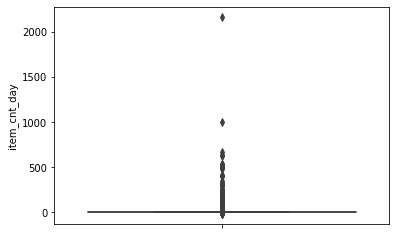

In [23]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sns.boxplot(y='item_cnt_day', data=train)

이상치가 많은 박스플롯, 모양이 이상함.

이상치 범위가 과도하게 넘어서 박스 모양이 납자해진 것임(1사분위 수, 2사분위 수, 3사분위 수)

과한 이상치는 제거해야는데, 얼마 이상을 이상치로 봐야하나? 여기서는 1,000 이상인 데이터를 제거할 것임.

#### 2-2. 판매가(상품 가격)

<AxesSubplot: ylabel='item_price'>

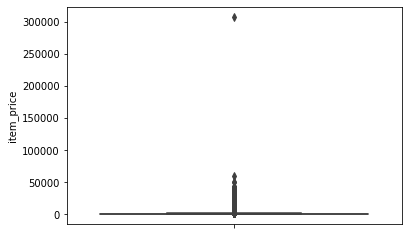

In [24]:
sns.boxplot(y='item_price', data=train)

여기서도 이상치가 큼.

판매가 50,000루블 이상인 이상치를 제거할 예정.

#### 2-3. 그룹화.
데이터를 특정 피처 기준으로 그룹화하여 그리기.

groupby()함수를 이용함. : 회귀 문제에서 자주 쓰이는 함수로 집곗값을 구할 때 사용함.
- train의 data_block_num 피처를 기준으로 그룹화하여 item_cnt_day 피처 값의 합을 구할 것임.

In [27]:
group = train.groupby('date_block_num').agg({'item_cnt_day' : 'sum'})
group.reset_index() #인덱스 재설정

# 인덱스 재설정을 안하면 date_block_num 피처가 인덱스가 되는데
# 그래프를 그릴때 date_block_num 피처를 사용해야해서 새로운 인덱스를 만듦.

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


#### groupby 동작원리
1. DataFrame에 있는 한 개 이상의 피처를 기준으로 데이터를 분리한다.
2. 분리된 각 그룹에 함수를 적용해 집곗값을 구한다. *agg() 메서드로 item_cnt_day 피처에 'sum'함수를 적용함.
3. 기준 피처별로 집곗값 결과를 하나로 합침

##### 2-1. 월별 판매량

[Text(0.5, 1.0, 'Distribution of monthly item counts by date block number'),
 Text(0.5, 0, 'Date block number'),
 Text(0, 0.5, 'Monthly item counts')]

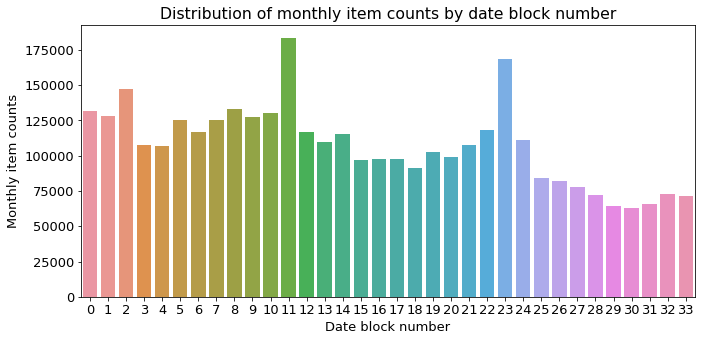

In [29]:
mpl.rc('font', size=13)
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 월별 총 상품 판매량
group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day' : 'sum'})
group_month_sum = group_month_sum.reset_index()

# 월별 총 상품 판매량 막대 그래프
sns.barplot(x='date_block_num', y='item_cnt_day', data=group_month_sum)

# 그래프 제목, x축 레이블, y축 레이블명 설정
ax.set(title='Distribution of monthly item counts by date block number',
      xlabel='Date block number',
      ylabel='Monthly item counts')

##### 2-2. 상품분류별 판매량
상품 분류는 총 84개로 피처 고유값 개수를 통해 알 수 있다.
84개 피처는 너무 많으니 판매량이 10,000개를 초과하는 상품 분류만 추출해서 그려보겠다.

In [30]:
train['item_category_id'].nunique()

84

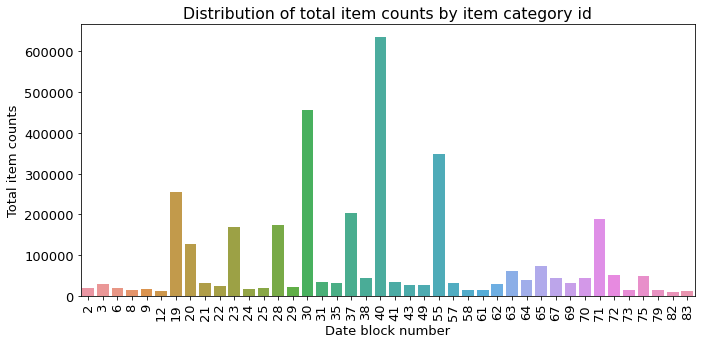

In [31]:
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day' : 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# 월간 판매량이 10,000개를 초과하는 상품 분류만 추출함.
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day'] > 10000]

# 상품분류별 총 상품 판매량 막대 그래프
sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
      xlabel='Date block number',
      ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # x축 레이블 회전

##### 2-3. 상점별 판매량
상점 개수는 60개 이므로, 역시 판매량이 10,000개를 초과하는 상점만 추린다.

In [ ]:
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 상점 별 총 상품 판매량
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day' : 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]

# 상점별 총 